In [72]:
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit, GridSearchCV

In [2]:
df = pd.read_csv("data/Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df.shape

(13320, 9)

In [4]:
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [5]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [7]:
df1 = df.drop(['area_type', 'society', 'balcony', 'availability'], axis='columns')
df1.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [8]:
df1.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [9]:
df2 = df1.dropna()
df2.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [10]:
df2.shape

(13246, 5)

In [11]:
df2['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [12]:
df2['bhk'] = df2['size'].apply(lambda x: int(x.split(' ')[0]))
df2.bhk.unique()

/tmp/ipykernel_106326/4049590364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['bhk'] = df2['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [13]:
df2.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [14]:
df2[df2.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [15]:
df2.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [16]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [17]:
df2[~df2['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple**

In [18]:
def covert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        match = re.match(r"([0-9]+\.?[0-9]*)", x)
        if match:
            return float(match.group(1))
        else:
            return None

In [19]:
covert_sqft_to_num('2100 - 2850')

2475.0

In [20]:
covert_sqft_to_num('34.46Sq. Meter')

34.46

In [21]:
df3 = df2.copy()
df3['total_sqft'] = df3['total_sqft'].apply(covert_sqft_to_num)
df3.head(10)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
5,Whitefield,2 BHK,1170.0,2.0,38.00,2
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3
9,Gandhi Bazar,6 Bedroom,1020.0,6.0,370.00,6


In [22]:
df3.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

## Feature Engineering

In [23]:
df4 = df3.copy()
df4['price_per_sqft'] = df4['price']*100000/df4['total_sqft']
df4.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [24]:
df4_stats = df4['price_per_sqft'].describe()
df4_stats

count    1.324600e+04
mean     1.238133e+04
std      2.262682e+05
min      2.678298e+02
25%      4.271866e+03
50%      5.446009e+03
75%      7.345855e+03
max      1.600000e+07
Name: price_per_sqft, dtype: float64

In [25]:
df4.to_csv("data/Bengaluru_House_Data_Cleaned.csv", index=False)

**As observe there are too many locations in the data set which is not good and there are some locations that have only to points in the following we are going to find those locations**

In [26]:
df4.location = df4.location.apply(lambda x: x.strip())
location_stats = df4.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

**Here we are going to eliminattes any locatio that have les that 10 data points that are going to be considered as other locations**

In [27]:
location_stats.values.sum()

13246

In [28]:
len(location_stats[location_stats>10])

241

In [29]:
len(location_stats)

1293

In [30]:
len(location_stats[location_stats<=10])

1052

## Dimensionality Reduction

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [31]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [32]:
len(df4.location.unique())

1293

In [33]:
df4.location = df4.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df4.location.unique())

242

In [34]:
df4.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


## Outilier Dection & Removal Using Business Logic

**As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [35]:
df4[df4.total_sqft/df4.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [36]:
df4.shape

(13246, 7)

In [37]:
df5 = df4[~(df4.total_sqft/df4.bhk<300)]
df5.shape

(12464, 7)

In [38]:
df5.price_per_sqft.describe()

count     12464.000000
mean       6308.291737
std        4167.032556
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [39]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [40]:
df6 = remove_pps_outliers(df5)
df6.shape

(10247, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

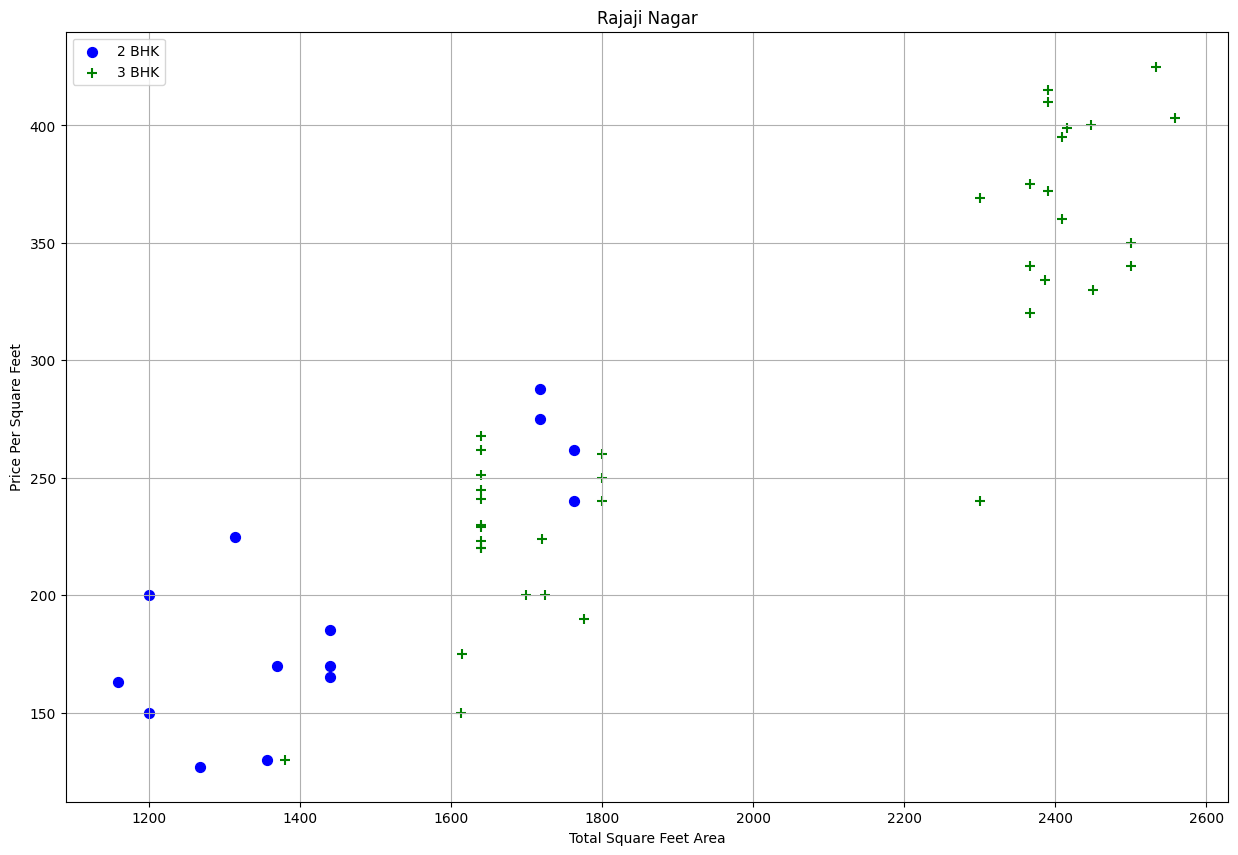

In [41]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]   
    matplotlib.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='+', color='green', label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price Per Square Feet")
    plt.title(location)
    plt.legend()
    plt.grid()

plot_scatter_chart(df6, "Rajaji Nagar")

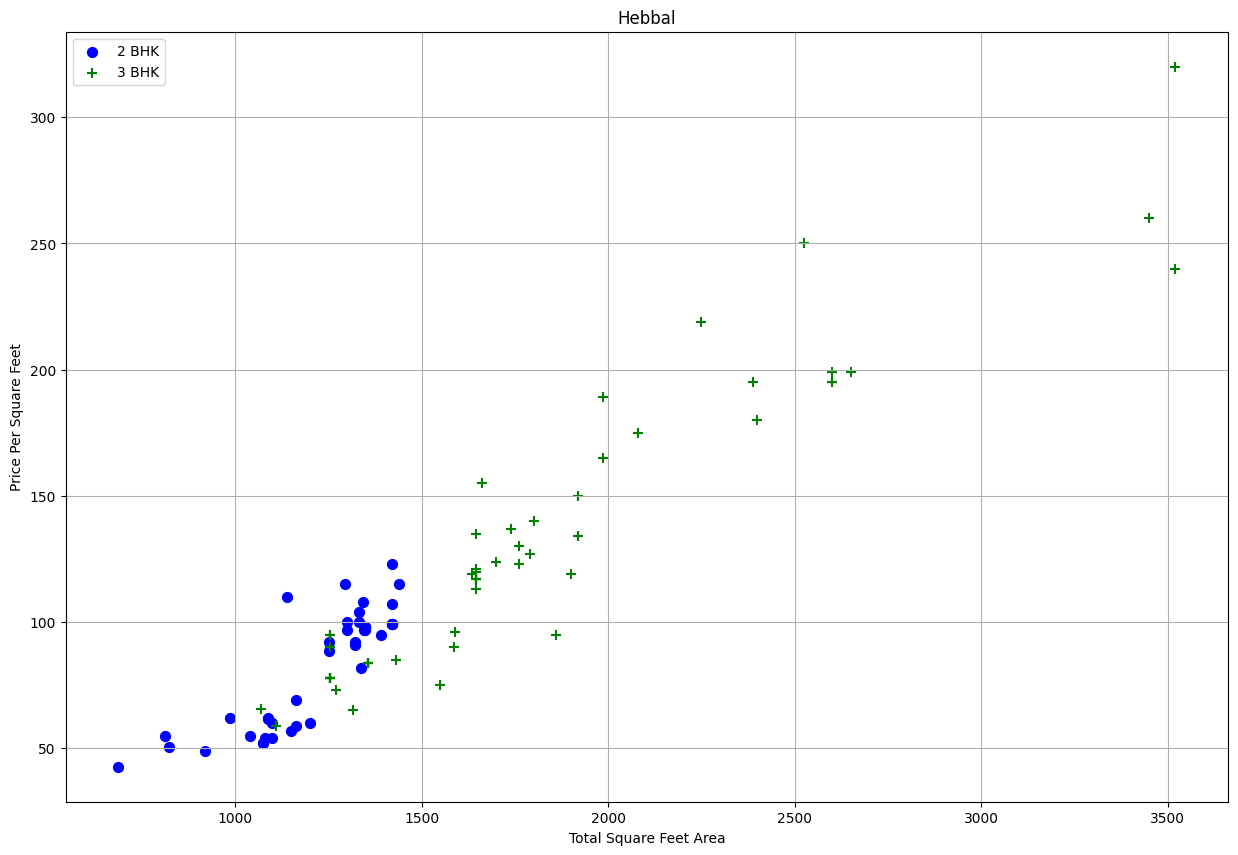

In [42]:
plot_scatter_chart(df6, "Hebbal")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
    $$
        {
            '1' : {
                'mean': 4000,
                'std: 2000,
                'count': 34
            },
            '2' : {
                'mean': 4300,
                'std: 2300,
                'count': 22
            },    
        }
    $$   

**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [43]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

In [44]:
df7 = remove_bhk_outliers(df6)
df7.shape

(7327, 7)

**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

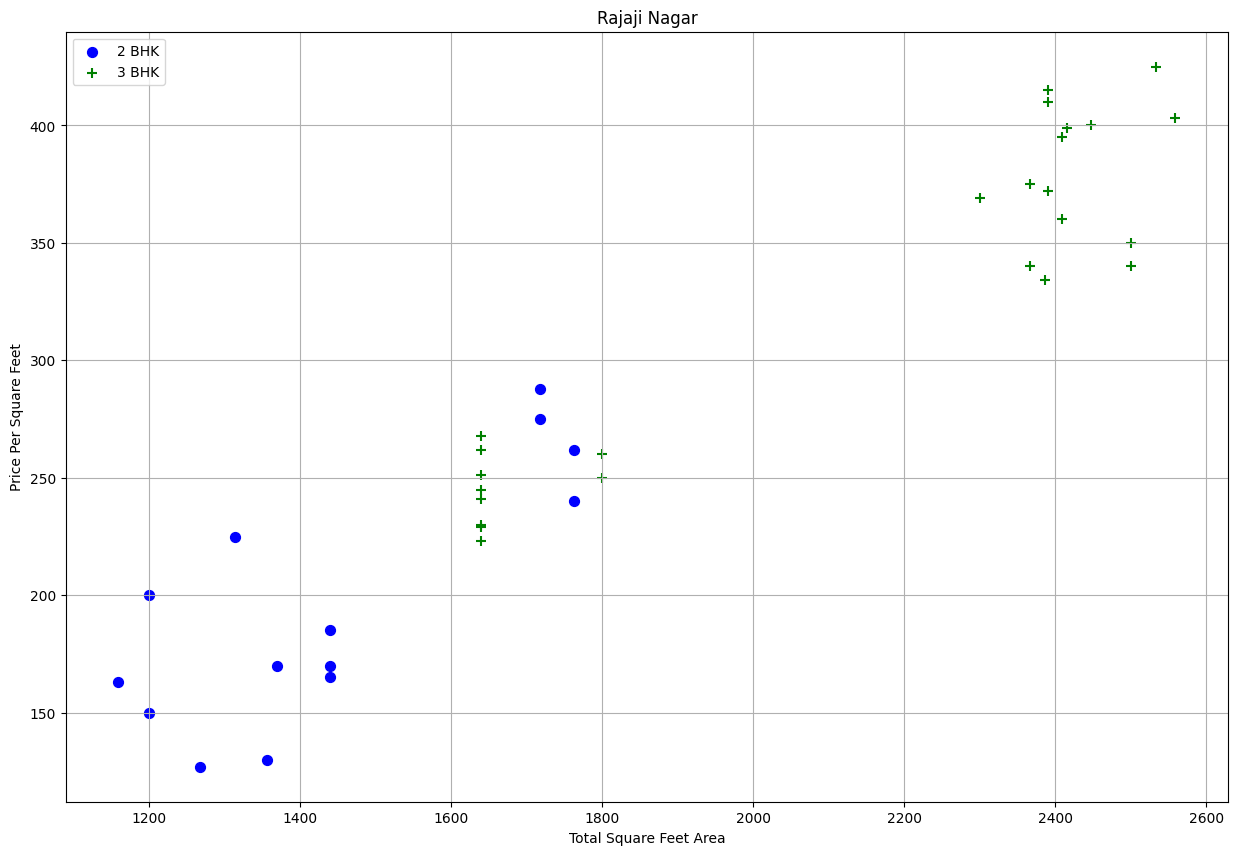

In [45]:
plot_scatter_chart(df7,"Rajaji Nagar")

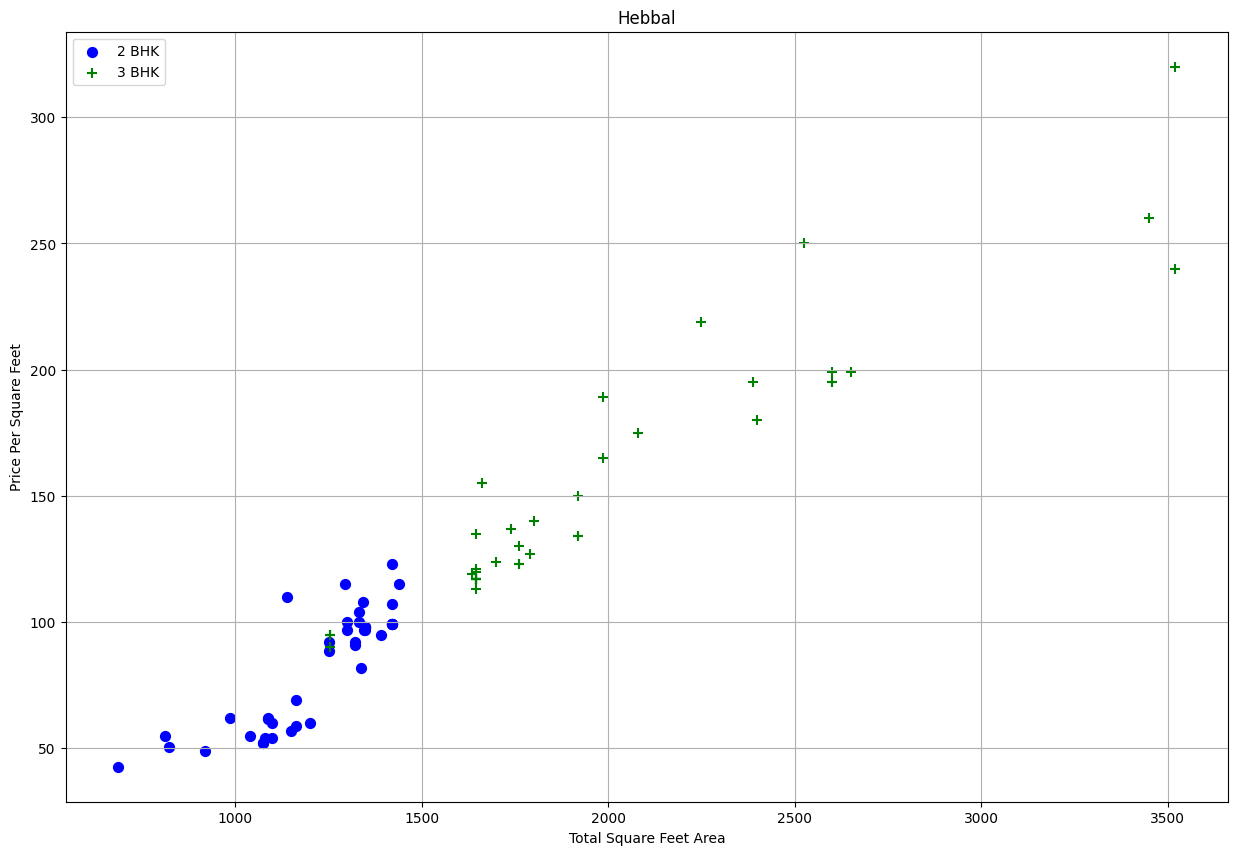

In [46]:
plot_scatter_chart(df7, "Hebbal")

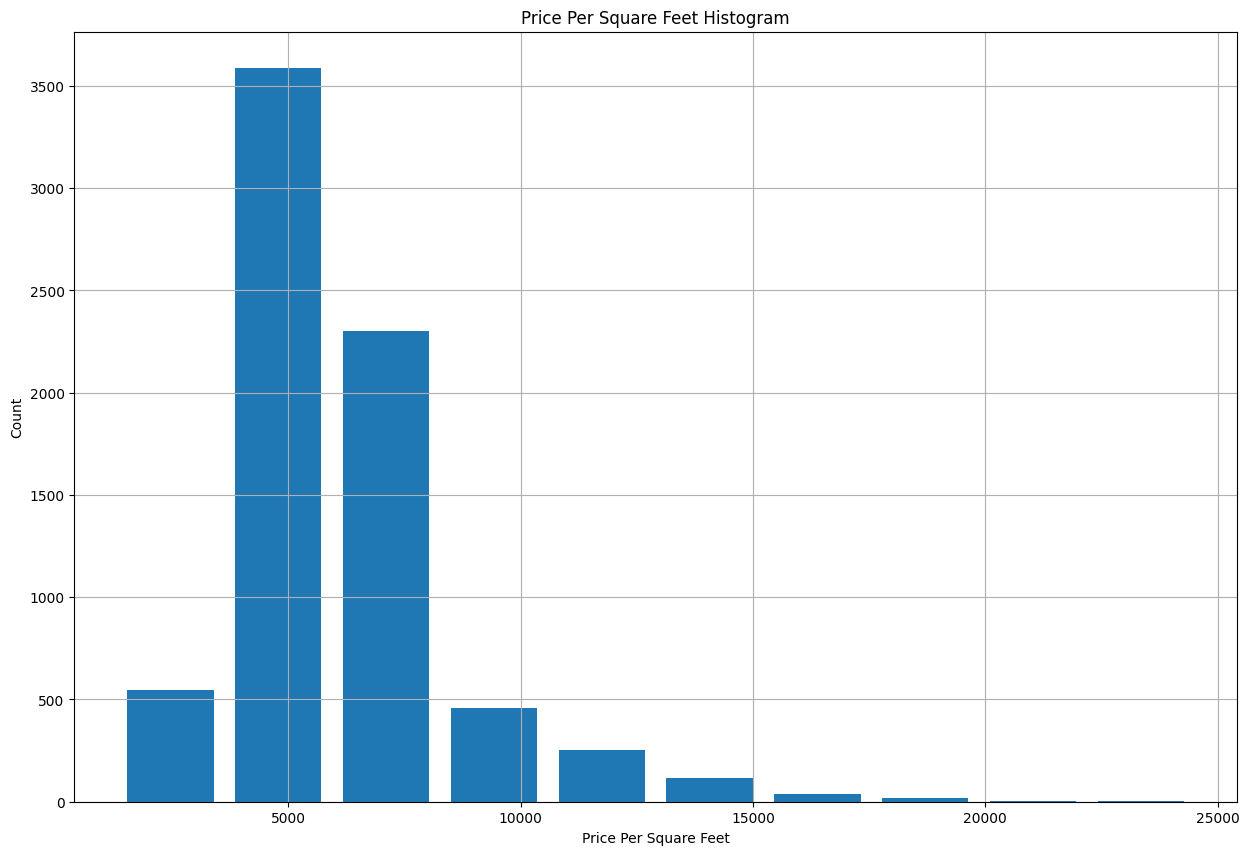

In [47]:
plt.hist(df7.price_per_sqft, rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")
plt.title("Price Per Square Feet Histogram")
plt.grid()
plt.show()

In [48]:
df7.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  9.,  7., 12., 16., 13.])

In [49]:
df7[df7.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5279,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8491,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8581,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9314,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9645,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


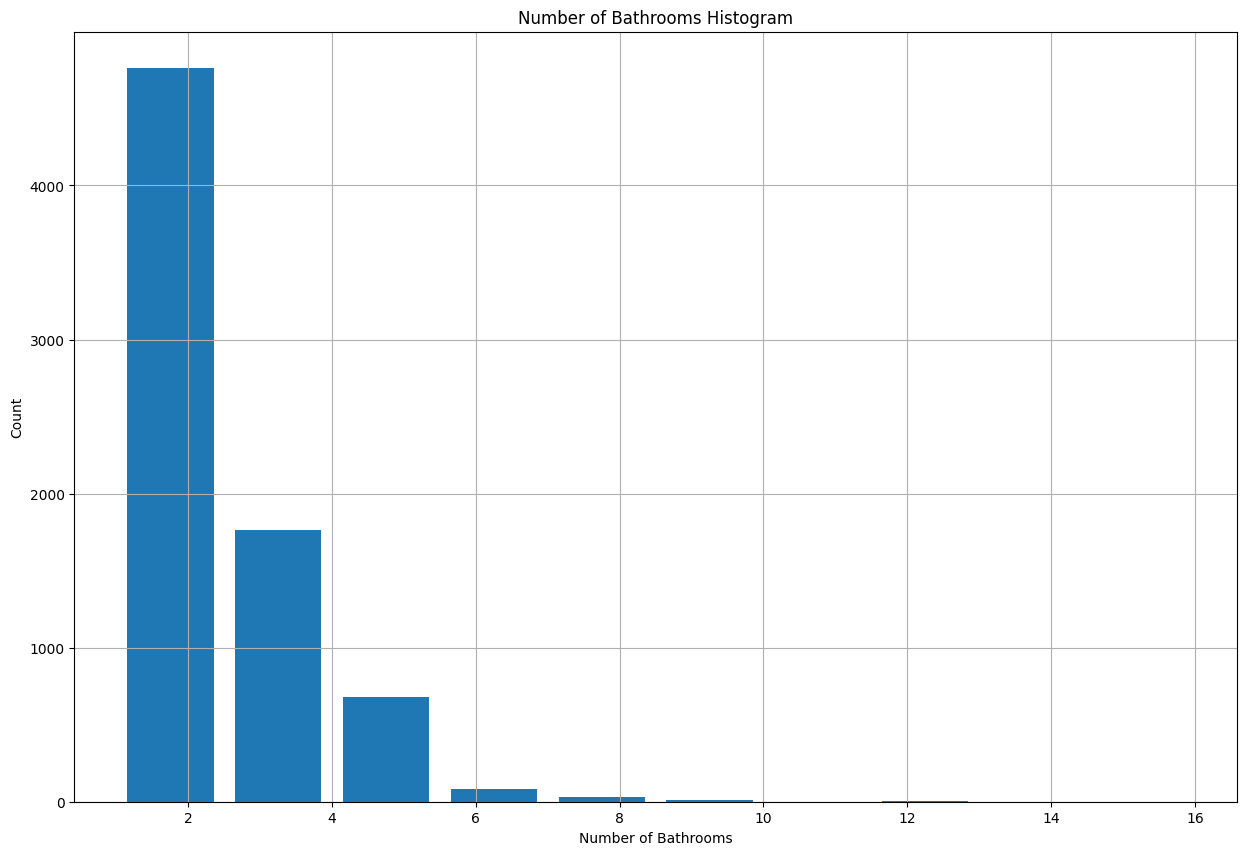

In [50]:
plt.hist(df7.bath, rwidth=0.8)
plt.xlabel("Number of Bathrooms")
plt.ylabel("Count")
plt.title("Number of Bathrooms Histogram")
plt.grid()
plt.show()

In [51]:
df7[df7.bath>df7.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1627,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5240,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6713,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8416,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


**Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [52]:
df8 = df7[df7.bath<df7.bhk+2]
df8.shape

(7249, 7)

In [53]:
df9 = df8.drop(['size', 'price_per_sqft'], axis='columns')
df9.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


In [54]:
dummies = pd.get_dummies(df9.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [55]:
df10 = pd.concat([df9, dummies.drop('other', axis='columns')], axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,194.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,235.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [56]:
df11 = df10.drop('location', axis='columns')
df11.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,194.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [57]:
df11.shape

(7249, 245)

In [58]:
X = df11.drop('price', axis='columns')
X.head(3)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [59]:
X.shape

(7249, 244)

In [60]:
y = df11.price
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [61]:
len(y)

7249

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [63]:
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8425655149713895

In [64]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.84377644, 0.8519563 , 0.83310272, 0.86189403, 0.86640923])

In [75]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['squared_error','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [76]:
find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.852331,{'fit_intercept': False}
1,lasso,0.702404,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.731469,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [80]:
X.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=244)

In [81]:
np.where(X.columns=='2nd Phase Judicial Layout')[0][0]

5

In [78]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [79]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

/home/redeus/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


83.34782469231112

In [82]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

/home/redeus/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


85.68925164433283

In [85]:
predict_price('1st Phase JP Nagar',1000, 2, 3)

/home/redeus/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


81.2501618170323

In [83]:
predict_price('Indira Nagar',1000, 2, 2)

/home/redeus/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


175.24638749434104

In [84]:
predict_price('Indira Nagar',1000, 3, 3)

/home/redeus/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


177.58781444636276

In [86]:
import joblib

# Assuming 'model' is your trained model
model_filename = 'house_price_model.joblib'
joblib.dump(lr_clf, model_filename)

print(f"Model saved to {model_filename}")

Model saved to house_price_model.joblib


In [87]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
columns_filename = "columns.json"
with open(columns_filename, "w") as f:
    f.write(json.dumps(columns))
print(f"Columns saved to {columns_filename}")

Columns saved to columns.json


Realised by: [Rudy Tchamba](https://github.com/RudyTchamba/RepoDatascience-MachineLearning.git)